# PhageHostLearn - v3.4.klebsiella - training

An AI-based Phage-Host interaction predictor framework with K-loci and receptor-binding proteins at its core. This particular PhageHostLearn is for *Klebsiella pneumoniae* related phages.

This notebook offers complete functionality to train a PhageHostLearn prediction model for Klebsiella phages starting from phage genomes, bacterial genomes and a matrix of known interactions.

**Overview of this notebook**
1. Initial set-up
2. Processing phage genomes and bacterial genomes into RBPs and K-locus proteins, respectively
3. Computing feature representations based on ESM-2
4. Training and evaluating the machine learning model

**Architecture of the PhageHostLearn framework**:
- Multi-RBP setting: phages consisting of one or more RBPs (multi-instance)
- K-loci proteins (multi-instance)
- Embeddings for both based on the ESM-2 language model
- An XGBoost model on top of the ESM-2 embeddings to make predictions

## 1. Initial set-up

PhageHostLearn takes as inputs phage genomes and bacterial genomes that are later transformed into phage RBPs and bacterial K-locus proteins. If you want to train a prediction model from scratch on phage and bacterial genomes, start from this step. If you want to reproduce our analyses from the processed RBPs and K-loci proteins in our Zenodo repository, go to `3. Feature construction`.

To do the data processing, you'll need to do the following:
1. Set up a folder for all the data that will be stored and generated by PhageHostLearn. Write the path to this folder in the code block below for 'general_path'.
2. In the folder, create two subfolders for the phage genomes and bacterial genomes (one for phage genomes and one for bacterial genomes). Collect both phage genomes and bacterial genomes as individual FASTA files and store them in the two separate folders.
3. Install [PHANOTATE](https://github.com/deprekate/PHANOTATE) and [Kaptive](https://github.com/katholt/Kaptive), both of which you'll need to process the phage and bacterial genomes. Locate PHANOTATE and write the path under the 2.1 code block below. Alternatively, copy the PHANOTATE file into your general folder. In addition, from the Kaptive repository, copy the .gbk databases into the general data folder.
4. Optionally install [bio_embeddings](https://github.com/sacdallago/bio_embeddings) to locally compute protein embeddings needed for RBP detection or opt do do this step in the cloud for faster results (see instructions below).
5. Install [fair-esm](https://github.com/facebookresearch/esm) to compute ESM-2 embeddings for the PhageHostLearn interaction prediction models.
6. Store the known interactions between phages and bacteria in an .xlsx file in which the first column is used for bacterial genome names and the first row is used for phage genome names. The names should correspond to the FASTA files in the respective folders.

In [ ]:
!git clone https://github.com/dimiboeckaerts/PhageHostLearn

In [ ]:
!pip install seaborn

In [ ]:
import psutil

# Get the total memory installed
total_memory_gb = psutil.virtual_memory().total / (1024 ** 3)

# Print the total memory
print(f"Total installed RAM: {total_memory_gb:.2f} GB")


In [8]:
import os
print(os.cpu_count())

64


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install biopython

In [3]:
import sys
sys.path.append("/home/PHL_Hope/PhageHostLearn/code")

In [4]:
general_path = '/home/PHL_Hope/PhageHostLearn/code/PHL_Data/'
data_suffix = 'Hope'

## 2. Data processing

The data processing of PhageHostLearn consists of five consecutive steps: (1) phage gene calling with PHANOTATE, (2) phage protein embedding with bio_embeddings, (3) phage RBP detection, (4) bacterial genome processing with Kaptive and (5) processing the interaction matrix.

In [ ]:
import phagehostlearn_processing as phlp

#### 2.1 PHANOTATE

In [ ]:
phage_genomes_path = general_path+'/phages_genomes'
phanotate_path = '/opt/homebrew/Caskroom/miniforge/base/envs/ML1/bin/phanotate.py'
phlp.phanotate_processing(general_path, phage_genomes_path, phanotate_path, data_suffix=data_suffix)

In [ ]:
phage_genomes_path = "/content/Combined_phage_Genome_protein.faa"

#### 2.2 Protein embeddings

The code block below computes protein embeddings for all of the detected phage genes (translated to proteins) using the bio_embeddings package (see `1. Initial set-up`). This might take a while on CPU. Alternatively, you can run this step in Google Colab or on Kaggle using the 'compute_embeddings_cloud.ipynb', which does exactly the same thing.

In [ ]:
phlp.compute_protein_embeddings(general_path, data_suffix=data_suffix)

#### 2.3 PhageRBPdetect

Either copy the `RBPdetect_phageRBPs.hmm` and `RBPdetect_xgb_hmm.json` files into the general data folder, or provide their absolute paths in the code block below, and then run the cell.

In [ ]:
import os
import json
import subprocess
import numpy as np
import pandas as pd
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SearchIO import HmmerIO
from tqdm.notebook import tqdm
from os import listdir
from xgboost import XGBClassifier
#from bio_embeddings.embed import ProtTransBertBFDEmbedder

In [ ]:
pfam_path = general_path+'/PhageHostLearn/code/RBPdetect_phageRBPs.hmm'
hmmer_path = '/content/drive/MyDrive/hmmer-3.4'
xgb_path = general_path+'/PhageHostLearn/code/RBPdetect_xgb_hmm.json'
gene_embeddings_path = general_path+'/phage_protein_embeddings'+data_suffix+'.csv'
phlp.phageRBPdetect(general_path, pfam_path, hmmer_path, xgb_path, gene_embeddings_path, data_suffix=data_suffix)

#### 2.4 Kaptive

In [ ]:
import json
from Bio import SeqIO
from Bio.Seq import Seq

def translate_sequences_to_proteins(fasta_file_path, output_json_path):
    """
    Translate nucleotide sequences from a FASTA file to protein sequences and save them in a JSON file.
    This function translates the complete sequence, ignoring internal stop codons.
    """
    loci_results = {}

    for seq_record in SeqIO.parse(fasta_file_path, "fasta"):
        nucleotide_sequence = str(seq_record.seq)

        # Ensure the sequence is a multiple of 3 by padding with 'N'
        while len(nucleotide_sequence) % 3 != 0:
            nucleotide_sequence += 'N'

        # Create a Seq object from the padded sequence
        padded_seq = Seq(nucleotide_sequence)

        # Translate the nucleotide sequence into a protein sequence without stopping at stop codons
        protein_sequence = str(padded_seq.translate(to_stop=False))

        # Remove any '*' characters that represent stop codons from the entire sequence
        protein_sequence = protein_sequence.replace('*', '')

        # Add the protein sequence to the dictionary under its accession number
        accession = seq_record.id.split()[0]  # Assuming the accession is the first part of the FASTA header
        if accession in loci_results:
            loci_results[accession].append(protein_sequence)
        else:
            loci_results[accession] = [protein_sequence]

    # Save the dictionary of proteins to a JSON file
    with open(output_json_path, 'w') as outfile:
        json.dump(loci_results, outfile, indent=4)

    print(f"Protein sequences have been translated and saved to {output_json_path}")

# Use the actual path to your FASTA file
fasta_file_path = '/content/drive/MyDrive/parsedoutputbact.fasta'

# Use the desired path for your output JSON file
output_json_path = '/content/drive/MyDrive/Locibase.json'

# Call the function
translate_sequences_to_proteins(fasta_file_path, output_json_path)


In [ ]:
bact_genomes_path = general_path+'/klebsiella_genomes/fasta_files'
kaptive_database_path = general_path+'/Klebsiella_k_locus_primary_reference.gbk'
phlp.process_bacterial_genomes(general_path, bact_genomes_path, kaptive_database_path, data_suffix=data_suffix)

#### 2.5 Process the interaction matrix

In [ ]:
interactions_xlsx_path = general_path+'/full_interaction_matrix.xlsx'
phlp.process_interactions(general_path, interactions_xlsx_path, data_suffix=data_suffix)

If you want to combine separate data sources of interactions, you can use the code block below.

In [ ]:
output = general_path+'/phage_host_interactions'+data_suffix
new_file = general_path+'/klebsiella_interactions_part2.xlsx' # part 2
phlp.add_to_database(output+'.csv', new_file, output)

## 3. Feature construction

Starts from the RBPbase.csv and the Locibase.json files that should be stored in the general_path. If you wish to reproduce our analyses, you can download these files from our [Zenodo repository](https://doi.org/10.5281/zenodo.8052911).

The last function outputs the ESM-2 feature matrix, labels, groups_loci and groups_phage (for evaluation). If the ESM-2 embeddings take too long, you might opt to do this step in the cloud or on a high-performance computer.

If you're retraining a model with the same data but new validated interactions, you can simply run the `construct_feature_matrices` function to construct updated feature matrices and labels and train models anew.

In [3]:
!pip install fair-esm

     |████████████████████████████████| 93 kB 1.6 MB/s eta 0:00:011


In [5]:
#pip install torch
import phagehostlearn_features as phlf

In [ ]:
import pandas as pd
import esm  # Assuming you have this library installed
import torch
from tqdm import tqdm
import numpy as np

def compute_esm2_embeddings_rbp(input_csv_path, output_csv_path, add=False, existing_embeddings_path=None):
    model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()
    batch_converter = alphabet.get_batch_converter()
    model.eval()

    RBPbase = pd.read_csv(input_csv_path)

    if add:
        old_embeddings_df = pd.read_csv(existing_embeddings_path)
        protein_ids = set(old_embeddings_df['name'])
        RBPbase = RBPbase[~RBPbase['name'].isin(protein_ids)]

    sequence_representations = []
    standard_amino_acids = set("ACDEFGHIKLMNPQRSTVWY")  # Add any other characters that are acceptable
    for i, sequence in tqdm(enumerate(RBPbase['ProteinSeq']), total=len(RBPbase)):
      cleaned_sequence = ''.join([aa for aa in sequence if aa in standard_amino_acids])
      if cleaned_sequence:  # Only proceed if the sequence is not empty after cleaning
        data = [(RBPbase.iloc[i]['name'], cleaned_sequence)]
        batch_labels, batch_strs, batch_tokens = batch_converter(data)
        with torch.no_grad():
            results = model(batch_tokens, repr_layers=[33], return_contacts=True)
        sequence_representations.append(results["representations"][33][0, 1:len(sequence) + 1].mean(0).tolist())

    phage_ids = RBPbase['name']
    embeddings_df = pd.concat([pd.DataFrame({'name':phage_ids}), pd.DataFrame(sequence_representations).astype('float')], axis=1)
    if add == True:
        embeddings_df = pd.DataFrame(np.vstack([old_embeddings_df, embeddings_df]), columns=old_embeddings_df.columns)
    embeddings_df.to_csv(output_csv_path, index=False)
    return


In [ ]:
compute_esm2_embeddings_rbp(
    input_csv_path="/content/drive/MyDrive/RBPbaseHope.csv",
    output_csv_path="/content/drive/MyDrive/esm2_embeddings_rbpHope.csv",
    add=False  # or True if you are adding to existing embeddings
)

In [ ]:
phlf.compute_esm2_embeddings_loci(general_path, data_suffix=data_suffix)

In [ ]:
!pip install tqdm


In [ ]:
!cd PHL_Data

In [ ]:
!ls

In [6]:
from tqdm.notebook import tqdm  # Import tqdm for Jupyter Notebook
import psutil

rbp_embeddings_path = general_path+'/esm2_embeddings_rbp'+data_suffix+'.csv'
loci_embeddings_path = general_path+'/esm2_embeddings_loci'+data_suffix+'.csv'

features_esm2, labels, groups_loci, groups_phage = phlf.construct_feature_matrices(general_path, 
                                                                            data_suffix, loci_embeddings_path, 
                                                                            rbp_embeddings_path)

100%|███████████████████████████████████████████████████████████████████████████████████| 4168/4168 [4:41:58<00:00,  4.06s/it]


Dimensions match? True


In [ ]:
np.save(general_path+'/esm2_features'+data_suffix+'.txt', features_esm2)
print(done)

In [ ]:
import sys
import gc

# Collecting garbage (optional, to clean up unreferenced objects)
gc.collect()

# Function to convert bytes to a more readable format
def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# Listing all variables and their sizes
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in globals().items()),
                         key= lambda x: -x[1])[:20]: # Adjust the slice [:10] to display more or fewer items
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))


In [ ]:
general_path = '/opt/data/home/nithya/JEMINA/PhageHostLearn/code/PHL_Data/'
data_suffix = 'Hope'

In [ ]:
feature_csv_path = general_path+"/features"+data_suffix+".csv"
labels_csv_path = general_path+"/labels"+data_suffix+".csv"
groups_loci_csv_path = general_path+"/groups_loci"+data_suffix+".csv"
groups_phage_csv_path = general_path+"/groups_phage"+data_suffix+".csv"

import numpy as np
import pandas as pd
import csv
# Read Labels, Groups_loci, and Groups_phage as lists
with open(labels_csv_path, 'r') as file:
    labels = [int(row[0]) for row in csv.reader(file)]
print("done")
with open(groups_loci_csv_path, 'r') as file:
    groups_loci = [row[0] for row in csv.reader(file)]
print("done")
with open(groups_phage_csv_path, 'r') as file:
    groups_phage = [row[0] for row in csv.reader(file)]
print("done")

# Read Features as NumPy array
features_esm2 = (pd.read_csv(feature_csv_path, header=None)).to_numpy()
print("done")

In [ ]:
with open(labels_csv_path, 'r') as file:
    labels = [int(row[0]) for row in csv.reader(file)]

In [ ]:
print(features_esm2[:100])

In [7]:
import psutil
initial = psutil.virtual_memory().available / 1024 **3

# Print the total memory
print(f"Total installed RAM: {initial:.5f}")

Total installed RAM: 198.02611


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
pandaa = psutil.virtual_memory().available / 1024 **2

# Print the total memory
print(f"Total installed RAM: {pandaa:.5f}")

In [ ]:
loci_embeddings_path = "/opt/data/home/nithya/JEMINA/features_outputHope.csv"
loci_embeddings = pd.read_csv(loci_embeddings_path)

In [ ]:
after = psutil.virtual_memory().available / 1024 **2

# Print the total memory
print(f"Total installed RAM: {after:.5f}")

In [ ]:
del loci_embeddings

In [ ]:
loci_embeddings_np=loci_embeddings.to_numpy()

In [ ]:
print(loci_embeddings_np)

In [ ]:
print(isinstance(loci_embeddings, np.ndarray))

In [ ]:
total_memory_gb = psutil.virtual_memory().available / 1024 **2

# Print the total memory
print(f"Total installed RAM: {total_memory_gb:.5f}")

In [ ]:
print(initial - pandaa)
print(pandaa - after)

In [ ]:
import sys

print(sys.getsizeof(features_esm2))

## 4. Training and evaluating models

In [ ]:
!pip install scikit-learn

In [16]:
import random
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import phagehostlearn_utils as phlu
import matplotlib.pyplot as plt
from matplotlib import cm
from joblib import dump, load
from tqdm.notebook import tqdm
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut, GroupShuffleSplit, GroupKFold
from sklearn.metrics import roc_auc_score, auc, precision_recall_curve, roc_curve
%matplotlib inline

In [10]:
results_path = general_path

In [ ]:
import sys
sys.path.append('D:/')

In [ ]:
!cd

In [11]:
cpus=60
labels = np.asarray(labels)

In [12]:
# ESM-2 FEATURES + XGBoost model
imbalance = sum([1 for i in labels if i==1]) / sum([1 for i in labels if i==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                    n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
xgb.fit(features_esm2, labels)
xgb.save_model(general_path+"phagehostlearn_esm2_xgb"+data_suffix+".json")

In [ ]:
!ls

#### 4.1 Training both models and saving them for later use

In [ ]:
cpus=6
import numpy as np

# Path to your labels CSV file
labels_csv_path = 'D:/labels_output'+data_suffix+'.csv'

# Load the labels directly into a NumPy array using np.loadtxt or np.genfromtxt
labels = np.loadtxt(labels_csv_path, delimiter=',')  # Assuming labels are separated by commas

# Ensure labels is a 1D NumPy array if it's not already
labels = labels.flatten()

# Now you can use labels in your machine learning model


In [ ]:
# ESM-2 FEATURES + XGBoost model
imbalance = sum([1 for i in labels if i==1]) / sum([1 for i in labels if i==0])
xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                    n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
xgb.fit(features_esm2, labels)
xgb.save_model('D:/phagehostlearn_esm2_xgb.json')

In [ ]:
!pip install dask

In [ ]:
labels = pd.read_csv('D:/labels_output'+'Hope'+'.csv', header=None).squeeze()

In [ ]:
data_suffix='Hope'

In [ ]:
import os
import dask.dataframe as dd
from xgboost import XGBClassifier
import pandas as pd
from tqdm import tqdm

# Parameters
data_suffix = 'Hope'
features_csv_path = 'D:/features_output' + data_suffix + '.csv'
labels_csv_path = 'D:/labels_output' + data_suffix + '.csv'
chunk_size = 10  # Number of rows per chunk
cpus = 6
model_path = 'D:/phagehostlearn_esm2_xgb'+ data_suffix + '.json'  # Model file path

# Read features CSV using Dask and labels into memory
print("Reading features dataset...")
ddf = dd.read_csv(features_csv_path)
print("Sample data from features:", ddf.head())  # Diagnostic print
print("Reading labels dataset...")
labels = pd.read_csv(labels_csv_path, header=None).squeeze()
print("Sample data from labels:", labels.head())  # Diagnostic print

# Class imbalance and XGBoost classifier initialization
print("Calculating class imbalance...")
imbalance = labels.value_counts()
scale_pos_weight = imbalance[0] / imbalance[1]
xgb = XGBClassifier(scale_pos_weight=scale_pos_weight, learning_rate=0.3, n_estimators=250, max_depth=7,
                    n_jobs=cpus, eval_metric='logloss')

# Processing chunks
print(len(labels))
print("Calculating total rows...")
total_rows = len(ddf)
print(total_rows)
print("Calculating total chunks...")
total_chunks = (total_rows + chunk_size - 1) // chunk_size  # Calculate the total number of chunks
print(total_chunks)
print(f"Processing {total_chunks} chunks...")
for i in tqdm(range(total_chunks)):
    start_idx = i * chunk_size
    end_idx = min((i + 1) * chunk_size, total_rows)
    df_chunk = ddf.loc[start_idx:end_idx-1].compute()  # end_idx is exclusive
    labels_chunk = labels.loc[start_idx:end_idx-1]

    if df_chunk.empty or len(df_chunk) != len(labels_chunk):
        print(f'Chunk {i} is empty or misaligned. Skipping.')
        continue

    # Incremental training: Load model if it exists
    if os.path.exists(model_path) and i > 0:
        xgb.load_model(model_path)
    xgb.fit(df_chunk, labels_chunk)

    # Save model after each iteration
    xgb.save_model(model_path)

print("Final model saved successfully.")


#### 4.2 LOGOCV with the combined model

In [21]:
!pip install ipywidgets


In [22]:
import gc
from tqdm import tqdm

logo = LeaveOneGroupOut()
cpus = 60
scores_lan = []
label_list = []
labels = np.asarray(labels)
pbar = tqdm(total=len(set(groups_phage)))
for train_index, test_index in logo.split(features_esm2, labels, groups_phage):
    print(test_index)
    # get the training and test data
    Xlan_train, Xlan_test = features_esm2[train_index], features_esm2[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    imbalance = sum([1 for i in y_train if i==1]) / sum([1 for i in y_train if i==0])

    ## ESM-2 EMBEDDINGS: XGBoost model
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                        n_jobs=cpus, eval_metric='logloss', use_label_encoder=False)
    xgb.fit(Xlan_train, y_train)
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    
    # save labels for later
    label_list.append(y_test)
    
    # pbar update
    pbar.update(1)
    gc.collect()
pbar.close()
# save results
logo_results = {'labels': label_list, 'scores_language': scores_lan}   
with open(results_path+'/combined_logocv_results_v34.pickle', 'wb') as f:
    pickle.dump(logo_results, f)



  0%|                                                                                                | 0/1401 [00:00<?, ?it/s]

[      0    1401    2802 ... 5835165 5836566 5837967]



  0%|                                                                               | 1/1401 [1:05:31<1528:57:27, 3931.61s/it]Exception ignored in: <function tqdm.__del__ at 0x7fbb534e5550>
Traceback (most recent call last):
  File "/home/PHL_Hope/.local/lib/python3.8/site-packages/tqdm/std.py", line 1149, in __del__
    self.close()
  File "/home/PHL_Hope/.local/lib/python3.8/site-packages/tqdm/notebook.py", line 278, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


[      1    1402    2803 ... 5835166 5836567 5837968]



  0%|                                                                               | 2/1401 [2:11:33<1534:47:16, 3949.42s/it]

[      2    1403    2804 ... 5835167 5836568 5837969]



  0%|▏                                                                              | 3/1401 [3:14:09<1499:21:01, 3860.99s/it]

[      3    1404    2805 ... 5835168 5836569 5837970]



  0%|▏                                                                              | 4/1401 [4:17:41<1490:47:01, 3841.68s/it]

[      4    1405    2806 ... 5835169 5836570 5837971]



  0%|▎                                                                              | 5/1401 [5:17:23<1453:26:38, 3748.14s/it]

[      5    1406    2807 ... 5835170 5836571 5837972]



  0%|▎                                                                              | 6/1401 [6:25:13<1494:49:34, 3857.62s/it]

[      6    1407    2808 ... 5835171 5836572 5837973]



  0%|▍                                                                              | 7/1401 [7:26:58<1474:20:54, 3807.50s/it]

[      7    1408    2809 ... 5835172 5836573 5837974]



  1%|▍                                                                              | 8/1401 [8:30:05<1470:50:29, 3801.17s/it]

[      8    1409    2810 ... 5835173 5836574 5837975]



  1%|▌                                                                              | 9/1401 [9:30:35<1449:03:36, 3747.57s/it]

[      9    1410    2811 ... 5835174 5836575 5837976]



  1%|▌                                                                            | 10/1401 [10:39:11<1491:57:36, 3861.29s/it]

[     10    1411    2812 ... 5835175 5836576 5837977]



  1%|▌                                                                            | 11/1401 [11:40:55<1472:20:54, 3813.28s/it]

[     11    1412    2813 ... 5835176 5836577 5837978]



  1%|▋                                                                            | 12/1401 [12:53:34<1535:17:38, 3979.16s/it]

[     12    1413    2814 ... 5835177 5836578 5837979]



  1%|▋                                                                            | 13/1401 [13:56:22<1509:34:39, 3915.33s/it]

[     13    1414    2815 ... 5835178 5836579 5837980]



  1%|▊                                                                            | 14/1401 [15:01:00<1504:06:11, 3903.95s/it]

[     14    1415    2816 ... 5835179 5836580 5837981]



  1%|▊                                                                            | 15/1401 [16:05:11<1496:52:06, 3887.97s/it]

[     15    1416    2817 ... 5835180 5836581 5837982]



  1%|▉                                                                            | 16/1401 [17:08:44<1487:06:34, 3865.41s/it]

[     16    1417    2818 ... 5835181 5836582 5837983]



  1%|▉                                                                            | 17/1401 [18:08:23<1452:59:07, 3779.44s/it]

[     17    1418    2819 ... 5835182 5836583 5837984]



  1%|▉                                                                            | 18/1401 [19:11:08<1450:13:18, 3774.98s/it]

[     18    1419    2820 ... 5835183 5836584 5837985]



  1%|█                                                                            | 19/1401 [20:14:21<1451:13:12, 3780.31s/it]

[     19    1420    2821 ... 5835184 5836585 5837986]



  1%|█                                                                            | 20/1401 [21:19:35<1465:34:51, 3820.49s/it]

[     20    1421    2822 ... 5835185 5836586 5837987]



  1%|█▏                                                                           | 21/1401 [22:21:21<1451:23:13, 3786.23s/it]

[     21    1422    2823 ... 5835186 5836587 5837988]



  2%|█▏                                                                           | 22/1401 [23:23:23<1442:52:44, 3766.76s/it]

[     22    1423    2824 ... 5835187 5836588 5837989]



  2%|█▎                                                                           | 23/1401 [24:23:46<1425:19:57, 3723.66s/it]

[     23    1424    2825 ... 5835188 5836589 5837990]



  2%|█▎                                                                           | 24/1401 [25:27:27<1435:27:15, 3752.82s/it]

[     24    1425    2826 ... 5835189 5836590 5837991]



  2%|█▎                                                                           | 25/1401 [26:28:30<1424:10:17, 3726.03s/it]

[     25    1426    2827 ... 5835190 5836591 5837992]


KeyboardInterrupt: 

In [27]:
print (len(test_index))
print ((label_list))

4168
[array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0])]


In [24]:
logo_results = {'labels': label_list, 'scores_language': scores_lan}   
with open(results_path+'/combined_logocv_results_v34.pickle', 'wb') as f:
    pickle.dump(logo_results, f)

In [ ]:
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from xgboost import XGBClassifier
from tqdm import tqdm
import numpy as np
import dask.dataframe as dd

# Parameters
features_csv_path = 'D:/features_output'+data_suffix+'.csv'  # Replace with your actual path
labels_csv_path = 'D:/labels_output'+data_suffix+'.csv'  # Replace with your actual path
groups_csv_path = 'D:/groups_loci_output'+data_suffix+'.csv'
chunk_size = 10000  # Adjust based on your memory capacity

print("Reading labels and group labels...")
labels = pd.read_csv(labels_csv_path, header=None).squeeze()
groups_loci = pd.read_csv(groups_csv_path, header=None).squeeze()

print("Reading features dataset...")
ddf = dd.read_csv(features_csv_path)

# Initialize LeaveOneGroupOut
logo = LeaveOneGroupOut()
scores_lan = []
label_list = []
pbar = tqdm(total=len(set(groups_loci)), desc="Processing LOGO Splits")

print("Starting LOGO cross-validation...")
# Iterate over groups
for train_index, test_index in logo.split(np.zeros_like(labels), labels, groups_loci):
    print(f"Processing split: {pbar.n + 1} of {len(set(groups_loci))}")
    
    # Process train and test chunks
    Xlan_train = ddf.loc[train_index].compute()
    Xlan_test = ddf.loc[test_index].compute()
    y_train, y_test = labels[train_index], labels[test_index]

    print("Training model...")
    # Model initialization and fitting
    imbalance = sum(y_train) / len(y_train)
    xgb = XGBClassifier(scale_pos_weight=1/imbalance, learning_rate=0.3, n_estimators=250, max_depth=7,
                        n_jobs=6, eval_metric='logloss')
    xgb.fit(Xlan_train, y_train)

    print("Predicting and scoring...")
    # Prediction and scoring
    score_xgb = xgb.predict_proba(Xlan_test)[:,1]
    scores_lan.append(score_xgb)
    label_list.append(y_test)

    # Progress update
    pbar.update(1)

pbar.close()
print("LOGO cross-validation completed.")


In [ ]:
# save results
logo_results = {'labels': label_list, 'scores_language': scores_lan}
with open('D:/v3.4/combined_logocv_results_v34Hope.pickle', 'wb') as f:
    pickle.dump(logo_results, f)

In [36]:
for i in range(25):
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


## 5. Results interpretation

In [37]:
# read results
with open(results_path+'/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
label_list = logo_results['labels']

# compute performance
rocaucs = []
praucs = []
rqueries_lan = []
random_guess = []
for i in range(25):
    score_lan = scores_lan[i]
    y_test = label_list[i]
    try:
            roc_auc = roc_auc_score(y_test, score_lan)
            rocaucs.append(roc_auc)
            precision, recall, thresholds = precision_recall_curve(y_test, score_lan)
            praucs.append(round(auc(recall, precision), 3))
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            random_guess.append(random.sample(ranked_lan, len(ranked_lan)))
    except:
        pass

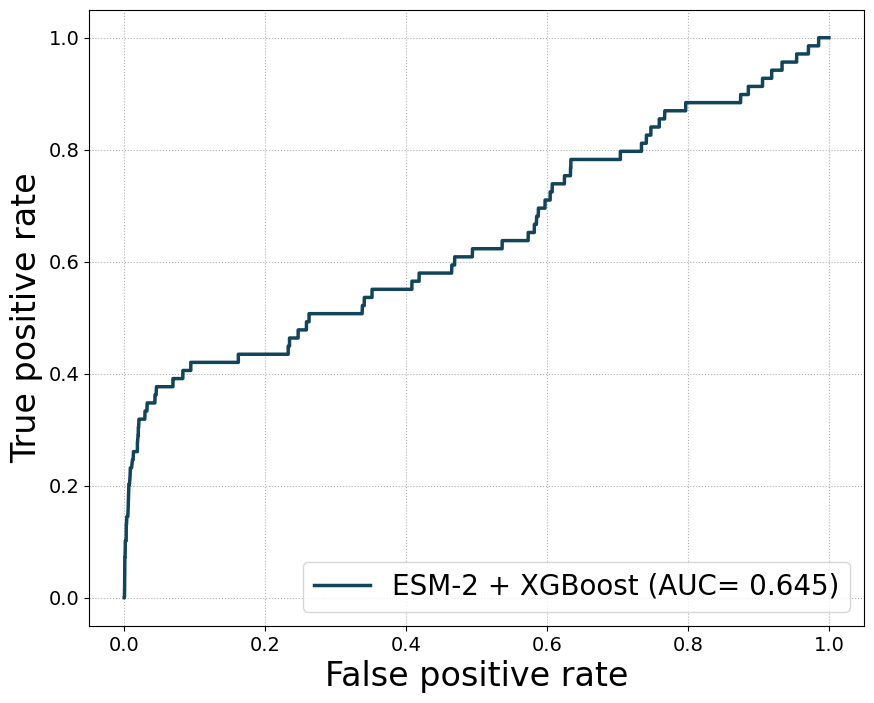

In [38]:
# results, ROC AUC
for i in range(25):#len(set(groups_loci))):
    score_lan = scores_lan[i]
    
labels = np.concatenate(label_list).ravel()
scoreslr = np.concatenate(scores_lan).ravel()

fig, ax = plt.subplots(figsize=(10,8))
fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost (AUC= '+str(rauclr)+')')
ax.set_xlabel('False positive rate', size=24)
ax.set_ylabel('True positive rate', size=24)
ax.legend(loc=4, prop={'size': 20})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/logocv_rocauc.png', dpi=400)
fig.savefig(results_path+'/logocv_rocauc_svg.svg', format='svg', dpi=400)

In [ ]:
import pickle
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
import random

# Assuming results_path is defined
results_path = 'D:/'

print("Reading the saved LOGO cross-validation results...")
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)

scores_lan = logo_results['scores_language']
label_list = logo_results['labels']

# Compute performance metrics
rocaucs = []
praucs = []
rqueries_lan = []
random_guess = []
total_groups = len(set(groups_loci))

print("Computing performance metrics...")
for i in range(total_groups):
    print(f"Processing group {i+1} of {total_groups}")
    score_lan = scores_lan[i]
    y_test = label_list[i]
    
    try:
        roc_auc = roc_auc_score(y_test, score_lan)
        rocaucs.append(roc_auc)
        
        precision, recall, thresholds = precision_recall_curve(y_test, score_lan)
        praucs.append(round(auc(recall, precision), 3))
        
        ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
        rqueries_lan.append(ranked_lan)
        
        random_guess.append(random.sample(ranked_lan, len(ranked_lan)))

        print(f"Group {i+1}: ROC AUC = {roc_auc}, PRAUC = {praucs[-1]}")
    except Exception as e:
        print(f"Error processing group {i+1}: {e}")

print("Performance metrics computation completed.")


#### ROC AUC curve

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

print("Preparing data for ROC curve...")
labels = np.concatenate(label_list).ravel()
scoreslr = np.concatenate(scores_lan).ravel()

print("Computing ROC curve and AUC...")
fpr, tpr, thrs = roc_curve(labels, scoreslr)
rauclr = round(auc(fpr, tpr), 3)

print("Creating static ROC curve plot with Matplotlib...")
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(fpr, tpr, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost (AUC= '+str(rauclr)+')')
ax.set_xlabel('False positive rate', size=24)
ax.set_ylabel('True positive rate', size=24)
ax.legend(loc=4, prop={'size': 20})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/v3.4/logocv_rocauc.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_rocauc_svg.svg', format='svg', dpi=400)

print("Creating interactive ROC curve plot with Plotly...")
interactive_fig = go.Figure()
interactive_fig.add_trace(go.Scatter(x=fpr, y=tpr, mode='lines', name='ESM-2 + XGBoost', line=dict(color='#124559', width=2.5)))
interactive_fig.update_layout(title='ROC Curve (AUC = '+str(rauclr)+')',
                              xaxis_title='False Positive Rate',
                              yaxis_title='True Positive Rate',
                              template='plotly_white')

# Save as HTML for interactive plot
interactive_fig.write_html(results_path+'/v3.4/logocv_rocauc_interactive.html')
print("ROC curve plots created and saved successfully.")


#### Hit ratio against microbiologist approach

In [ ]:
import pandas as pd
import numpy as np
import json
import random

# prep the data
interactions1 = general_path+'/klebsiella_phage_host_interactions.xlsx'
interactions2 = general_path+'/klebsiella_interactions_part2.xlsx' # for part 1 NO SUGGESTIONS POSSIBLE -> ALL UNIQUE K-TYPES
matrix1 = pd.read_excel(interactions1, index_col=0, header=0)
matrix2 = pd.read_excel(interactions2, index_col=0, header=0)
locipath = general_path+'/LocibaseValencia.json'
seros = pd.read_csv(general_path+'/serotypesValencia.csv')
with open(locipath) as f:
    locibase = json.load(f)

# do the informed approach
hits = {i: 0 for i in range(1, 51)}
total = 0
# --------------------
# MATRIX 1
# --------------------
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]

# phages sorted by broad-spec
sorted_phages = matrix1.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix1.index.values)
no_genome = ['K2', 'K21', 'K23', 'K27', 'K28', 'K40', 'K45', 'K48', 'K52', 'K53', 'K67', 'K69', 'K70', 'K71', 'K72']
rownames = [str(i) for i in rownames if i not in no_genome]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

# iterate over all accessions in matrix1
for i, accession in enumerate(rownames):
    # only compute hit ratio when we can find something
    if sum(matrix1.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix1 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix1.columns[matrix1.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix1[x].sum(), reverse=True)

        total += 1
        for k in range(1, 51):
            # approach 1: if we dont have enough suggestions, pick extra at random from total pool available
            # approach 2: now, we supplement them with the sorted phages by broad-spectrum, not random!
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]

            #suggested = random.sample(phage_suggestions, k)
            if any([matrix1.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1

# --------------------
# MATRIX 2
# --------------------
hits2 = {i: 0 for i in range(1, 51)}
total2 = 0
loci_serotype = {}
for i, accession in enumerate(locibase.keys()):
    loci_serotype[accession] = seros['sero'][i]

sorted_phages = matrix2.sum().sort_values(ascending=False).index.tolist()

# delete keys not in this matrix (only suggestions within the matrix)
rownames = list(matrix2.index.values)
rownames = [str(i) for i in rownames]
for key in list(loci_serotype.keys()):
    if key not in rownames:
        del loci_serotype[key]

# iterate over all accessions in matrix2
for i, accession in enumerate(matrix2.index.values):
    # only compute hit ratio when we can find something
    if sum(matrix2.loc[accession]) > 0:
        # get the serotype
        serotype = loci_serotype[str(accession)]
        # search other bacteria with the same serotype
        same_serotype = [key for key, value in loci_serotype.items() if value == serotype]
        same_serotype.remove(str(accession))
        # get phage suggestions: columnnames of corresponding bacteria in matrix2 with value = 1
        phage_suggestions = []
        for j, acc in enumerate(same_serotype):
            if acc in ['132', '779', '806', '228', '245', '406', '1210', '1446', '1468', '1572', '2164']:
                acc = int(acc)
            colnames = matrix2.columns[matrix2.loc[acc] == 1].tolist()
            phage_suggestions.append(colnames)
        # flatten the list
        phage_suggestions = list(set([item for sublist in phage_suggestions for item in sublist]))
        # sort the list based: most narrow phages first!
        phage_suggestions.sort(key=lambda x: matrix2[x].sum(), reverse=True)

        total += 1
        total2 += 1
        for k in range(1, 51):
            # if we dont have enough suggestions, pick extra at random from the total pool
            if k > len(phage_suggestions):
                sample_pool = [sugg for sugg in sorted_phages if sugg not in phage_suggestions]
                to_pick = k-len(phage_suggestions)
                if len(sample_pool) < to_pick:
                    phage_suggestions = phage_suggestions + sample_pool
                else:
                    phage_suggestions = phage_suggestions + sample_pool[:to_pick]

            if any([matrix2.loc[accession, sugg] == 1 for sugg in phage_suggestions]):
                hits[k] += 1
                hits2[k] += 1

informed_hitratio = {k: v/total for k, v in hits.items()}
informed_hitratio2 = {k: v/total2 for k, v in hits2.items()}

In [ ]:
# results, hit ratios @ K
ks = np.linspace(1, 50, 50)
hits_lan = [phlu.hitratio(rqueries_lan, int(k)) for k in ks]
hits_random = [phlu.hitratio(random_guess, int(k)) for k in ks]
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(ks, hits_lan, c='#124559', linewidth=2.5, label='ESM-2 + XGBoost')
#ax.plot(ks, hits_ens, c='#124559', linewidth=2.5, label='Combined model')
#ax.plot(ks, hits_random, c='#81B29A', linewidth=2.5, ls=':', label='Random guess')
ax.plot(ks, list(informed_hitratio.values()), c='#E15554', linewidth=2.5, ls='-.', label='Informed microbiologist')
#ax.plot(ks, list(informed_hitratio2.values()), c='#E15554', linewidth=2.5, ls=':', label='Informed guess (Bea only)')
ax.set_xlabel('$\it{k}$', size=24)
ax.set_ylabel('Hit ratio @ $\it{k}$', size=24)
ax.set_ylim(0.1, 1)
ax.legend(loc=4, prop={'size': 24})
ax.grid(True, linestyle=':')
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed.png', dpi=400)
fig.savefig(results_path+'/v3.4/logocv_hitratio_informed_svg.svg', format='svg', dpi=400)

#### Performance per K-type

https://medium.com/@curryrowan/simplified-logistic-regression-classification-with-categorical-variables-in-python-1ce50c4b137

In [ ]:
# read results
with open(results_path+'/v3.4/combined_logocv_results_v34.pickle', 'rb') as f:
    logo_results = pickle.load(f)
scores_lan = logo_results['scores_language']
scores_hdc = logo_results['scores_hdc']
label_list = logo_results['labels']

# read K-types
seros = pd.read_csv(general_path+'/serotypesValencia.csv')

In [ ]:
# mean hit ratio per K-type
unique_seros = list(set(seros['sero']))
performance_ktypes = {}
labelcount_ktypes = {}
for unique in unique_seros:
    indices = seros['sero'] == unique
    subscores_lan = [val for is_good, val in zip(indices, scores_lan) if is_good]
    subscores_hdc = [val for is_good, val in zip(indices, scores_hdc) if is_good]
    sublabels = [val for is_good, val in zip(indices, label_list) if is_good]
    labelcount_ktypes[unique] = [sum(i) for i in sublabels]
    rqueries_lan = []
    rqueries_hdc = []
    rqueries_ens = []
    for i in range(len(subscores_lan)):
        score_lan = subscores_lan[i]
        score_hdc = subscores_hdc[i]
        score_ens = [phlu.uninorm(score_lan[j], score_hdc[j]) for j in range(len(score_lan))]
        y_test = sublabels[i]
        if sum(y_test) > 0:
            ranked_lan = [x for _, x in sorted(zip(score_lan, y_test), reverse=True)]
            ranked_hdc = [x for _, x in sorted(zip(score_hdc, y_test), reverse=True)]
            ranked_ens = [x for _, x in sorted(zip(score_ens, y_test), reverse=True)]
            rqueries_lan.append(ranked_lan)
            rqueries_hdc.append(ranked_hdc)
            rqueries_ens.append(ranked_ens)
    if len(rqueries_lan) > 0:
        hr_lan = round(phlu.hitratio(rqueries_lan, 10), 3)
        hr_hdc = round(phlu.hitratio(rqueries_hdc, 10), 3)
        hr_ens = round(phlu.hitratio(rqueries_ens, 10), 3)
        performance_ktypes[unique] = [('HR_XGB', hr_lan), ('HR_HDC', hr_hdc), ('HR_COMBINED', hr_ens)]
    #else:
    #    performance_ktypes[unique] = [('MAR_XGB', np.nan), ('MAR_HDC', np.nan), ('MAR_COMBINED', np.nan)]

In [ ]:
performance_hr_xgb = []
for ktype in performance_ktypes:
    performance_hr_xgb.append(performance_ktypes[ktype][0][1])
sortedpairs = [(x,y) for y, x in sorted(zip(performance_hr_xgb, list(performance_ktypes.keys())), reverse=True)]
fig, ax = plt.subplots(figsize=(16,6))
ax.hist(performance_hr_xgb, bins=25, color='#124559')
#sns.barplot(x=[score for (key, score) in sortedpairs], y=[key for (key, score) in sortedpairs], ax=ax, palette='magma')
ax.set_xlabel('Mean top-10 hit ratio', size=22)
ax.set_ylabel('Number of K-types', size=22)
ax.yaxis.set_tick_params(labelsize = 14)
ax.xaxis.set_tick_params(labelsize = 14)
fig.tight_layout()
fig.savefig(results_path+'/v3.4/histogram_ktypes_svg.svg', format='svg', dpi=400)

#### Hit ratio per K-type versus number of pos labels

In [ ]:
top10 = [x[0] for x in sortedpairs if x[1] == 1] # all with HR == 1
bottom10 = [x[0] for x in sortedpairs if x[1] == 0] # all with HR == 0
middle = [x[0] for x in sortedpairs if (x[1] != 0 and x[1] != 1)]
countst10 = []
countsb10 = []
countsmid = []
for key in labelcount_ktypes.keys():
    if key in top10:
        countst10.append(labelcount_ktypes[key])
    elif key in bottom10:
        countsb10.append(labelcount_ktypes[key])
    elif key in middle:
        countsmid.append(labelcount_ktypes[key])
countst10 = [i for x in countst10 for i in x]
countsb10 = [i for x in countsb10 for i in x]
countsmid = [i for x in countsmid for i in x]

In [ ]:
countlist = [countst10, countsmid, countsb10]
binlist = [20, 15, 15]

for i, count in enumerate(countlist):
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.histplot(count, ax=ax, color='#221150', bins=binlist[i])
    ax.set_xlim(0, 10)
    ax.set_xlabel('Number of confirmed interactions', size=22)
    ax.set_ylabel('Number of bacteria', size=22)
    ax.yaxis.set_tick_params(labelsize = 14)
    ax.xaxis.set_tick_params(labelsize = 14)
    fig.savefig(results_path+'/v3.4/ktypecounts_svg'+str(i)+'.svg', format='svg', dpi=400)